<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/modelagen_hateSpeech_com_Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoBERTa

In [ ]:
!pip install -q transformers
!pip install -q magic_timer

In [ ]:
import os
import gc
import re
import itertools
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader

from magic_timer import MagicTimer

from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
from transformers import AdamW

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
nltk.download('stopwords')

MANUAL_SEED = 42
np.random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Leitura do dataset de treino

In [ ]:
base_path = "/content/drive/MyDrive/Programação/EXTECAMP/619 - Zanoni - Projeto Final/"
df_train = pd.read_csv(base_path+"train.csv", index_col=None)
print("quantidade de exemplos:", df_train.shape)

# adicionando uma coluna que conta o numero de palavras
len_words = df_train.tweet.apply(lambda x: len(x.split(" ")))
df_train["num_words"] = len_words

# Analisando o maior tweet
print('tweet com comprimento maximo (numero de palavras):', df_train["num_words"].max())
max_tweet = df_train[df_train["num_words"]==df_train["num_words"].max()].tweet.to_list()[0]
print(max_tweet)

quantidade de exemplos: (19826, 7)
tweet com comprimento maximo (numero de palavras): 36
' She herd I was a dope boy , I herd she was a gold digger &#1043359; , all I know is she a real bitch , so I fuck her like a real niggah .


# Balanceamento da classe

In [ ]:
hate_tweets = df_train[df_train['class']==0]
offensive_tweets = df_train[df_train['class']==1]
neither = df_train[df_train['class']==2]
print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)

(1140, 8)
(15358, 8)
(3328, 8)


## Under-Sampling

(1140, 8)
(1140, 8)
(1140, 8)
Hate Speech  :  1140
Offensive Language  :  1140
None  :  1140


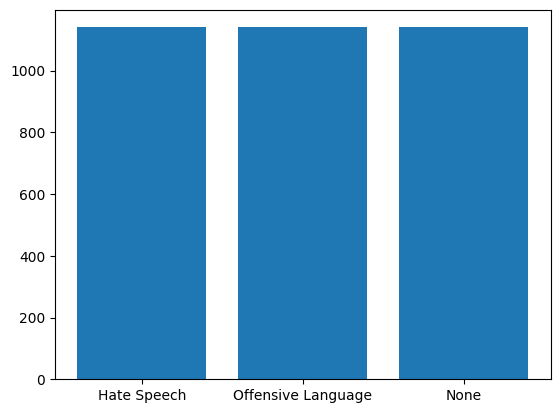

In [ ]:
offensive_tweets = offensive_tweets.iloc[0:1140,:]
neither = neither.iloc[0:1140,:]
print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)

df_undersampling = pd.concat([hate_tweets, offensive_tweets, neither],ignore_index=True)

labels = df_undersampling['class']
classes = ['Hate Speech','Offensive Language','None']
unique, counts = np.unique(labels, return_counts=True)
values = list(zip(unique, counts))
plt.bar(classes,counts)
for i in values:
    print(classes[i[0]],' : ',i[1])
plt.show()

## Over-Sampling

(8000, 8)
(8000, 8)
(8000, 8)
Hate Speech  :  8000
Offensive Language  :  8000
None  :  8000


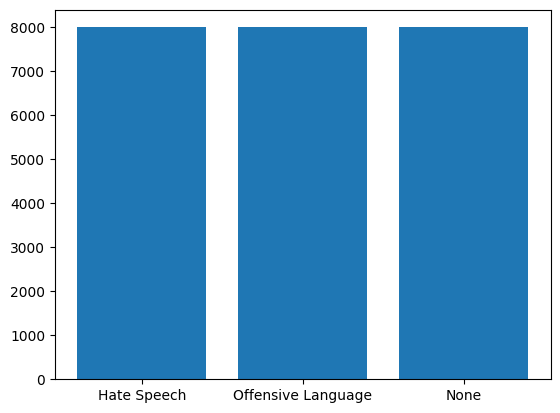

In [ ]:
hate_tweets = df_train[df_train['class']==0]
offensive_tweets = df_train[df_train['class']==1]
neither = df_train[df_train['class']==2]

K_exemplos = 8_000
for i in range(3):
    hate_tweets = pd.concat([hate_tweets,hate_tweets],ignore_index = True).iloc[0:K_exemplos,:]
neither = pd.concat([neither,neither,neither], ignore_index = True).iloc[0:K_exemplos,:]
offensive_tweets = offensive_tweets.iloc[0:K_exemplos,:]

print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)

df_oversampling = pd.concat([hate_tweets,offensive_tweets,neither],ignore_index = True)

labels = df_oversampling['class']
classes = ['Hate Speech','Offensive Language','None']
unique, counts = np.unique(labels, return_counts=True)
values = list(zip(unique, counts))
plt.bar(classes,counts)
for i in values:
    print(classes[i[0]],' : ',i[1])
plt.show()

# Data Clean

In [ ]:
# dealing with Slangs
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food', 'u': 'you',
     'ur':'your', 'bday' : 'birthday', 'bihday' : 'birthday'} ## Need a huge dictionary

stop_words = set(stopwords.words("english"))
stop_words.add('rt')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()
giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'

def clean_text(text):
    text = re.sub('"', "", text)
    text = re.sub(mention_regex, ' ',text) #removing all user names
    text = re.sub(giant_url_regex, ' ', text)  #remocing the urls
    text = text.lower()
    text = re.sub("hm+", "", text) #removing variants of hmmm
    text = re.sub("[^a-z]+", " ", text) #removing all numbers, special chars like @,#,? etc
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = [d[word] if word in d else word for word in text]  #replacing some slangs
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

df_undersampling['processed_tweets'] = df_undersampling.tweet.apply(lambda x: clean_text(x))
df_oversampling['processed_tweets'] = df_oversampling.tweet.apply(lambda x: clean_text(x))

## Analise da qtde de tokens

In [ ]:
path_model = 'bert-base-uncased'
tokenizer = RobertaTokenizerFast.from_pretrained(path_model)

def contar_tokens(texto):
    tokens = tokenizer.tokenize(texto)
    return len(tokens)

textos_limpos = df_oversampling.processed_tweets.to_list()
numero_de_tokens_limpos = [contar_tokens(texto) for texto in textos_limpos]
mediana_limpos = np.median(numero_de_tokens_limpos)
p90_limpos = np.percentile(numero_de_tokens_limpos, 90)
print(f"Texto limpo - Mediana: {mediana_limpos}")
print(f"Texto limpo - P90: {p90_limpos}")

textos = df_oversampling.tweet.to_list()
numero_de_tokens = [contar_tokens(texto) for texto in textos]
mediana = np.median(numero_de_tokens)
p90 = np.percentile(numero_de_tokens, 90)
print(f"\nMediana: {mediana}")
print(f"P90: {p90}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Texto limpo - Mediana: 9.0
Texto limpo - P90: 17.0

Mediana: 26.0
P90: 45.0


# Funções para o treino com K-fold

In [ ]:
BSIZE = 128
MAX_LEN = 50

def get_tokens(data, label, maxlen):
    ids, labels = [], []
    for text, label in zip(data, label):
        tokens = tokenizer.encode_plus(
            text=text,
            truncation=True,
            max_length=maxlen,
            padding='max_length',
            return_tensors='pt'
        )
        labels.append(int(label))
        ids.append(tokens['input_ids'])

    ids = torch.vstack(ids)
    return ids, torch.tensor(labels)


def train_one_epoch(model, dataloader, optim, device='cpu'):
    total_loss = []
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    for batch in dataloader:
        model.zero_grad()
        batch_ids, batch_label = (b.to(device) for b in batch)

        with torch.autocast(device_type=device, dtype=torch.float16):
            outs = model(input_ids=batch_ids, labels=batch_label)
        assert outs['logits'].dtype is torch.float16


        loss = outs['loss']


        total_loss.append(loss.item())

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()

    return np.array(total_loss).mean()

def evaluate(model, loader, device):
    trues, preds = [],[]
    eval_loss = []
    model.eval()
    for batch in loader:
        model.zero_grad()

        batch_ids, batch_label = (b.to(device) for b in batch)

        with torch.no_grad():
            outs = model(input_ids=batch_ids, labels=batch_label)

        loss = outs['loss']
        eval_loss.append(loss.item())
        pred = outs['logits'].argmax(-1).detach().cpu().numpy()
        preds.extend(pred)

        trues.extend(batch_label.detach().cpu().numpy().tolist())

    acc = balanced_accuracy_score(trues, preds)
    eval_loss_mean = np.array(eval_loss).mean()

    return eval_loss_mean, acc, trues, preds

def train(model, train_loader, valid_loader, optim, n_epochs, timer, device='cpu'):
    train_losses = []
    accs = []
    best_acc = -1
    best_epoch = 0
    best_model = None
    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_loader, optim, device)
        eval_loss_mean, accScore, trues, preds = evaluate(model, valid_loader, device)

        train_losses.append(train_loss)

        accs.append(accScore)

        if accScore > best_acc:
            best_acc = accScore
            best_epoch = epoch + 1
            best_model = model

        print(f'ep: [{epoch+1}/{n_epochs}] -- Train Loss: {train_loss:.3} -- Eval Loss: {eval_loss_mean:.3} -- ACC: {accScore:.3} -- time elapsed: {timer}')

    return best_acc, best_epoch, best_model


def perform_kfold_cv(df, k_folds, column_name='tweet', n_epochs=10, random_state=MANUAL_SEED, device='cpu', batch_size=BSIZE):
    skf = StratifiedKFold(n_splits=k_folds, random_state=random_state, shuffle=True)
    folds_acc = []
    trained_models = []

    for fold, (train_index, eval_index) in enumerate(skf.split(np.zeros(df.shape[0]), df['class'])):
        timer = MagicTimer()
        print()
        print(f'--- K Fold [{fold+1}/{k_folds}] ---')
        model = RobertaForSequenceClassification.from_pretrained(
            path_model,
            num_labels=df['class'].nunique(),
            return_dict=True,
            ignore_mismatched_sizes=True,
        ).to(device)
        model.classifier.out_proj = torch.nn.Linear(model.config.hidden_size, 3).to(device)

        optim = torch.optim.AdamW(model.parameters(), lr=4e-5)

        X_train, y_train = df[column_name][train_index], df['class'][train_index]
        X_eval, y_eval = df[column_name][eval_index], df['class'][eval_index]

        train_texts, train_labels = get_tokens(X_train.to_list(), y_train.to_list(), MAX_LEN)
        eval_texts, eval_labels = get_tokens(X_eval.to_list(), y_eval.to_list(), MAX_LEN)

        dataset_train = TensorDataset(train_texts, train_labels)
        dataset_eval  = TensorDataset(eval_texts, eval_labels)

        train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(dataset=dataset_eval, batch_size=batch_size, shuffle=False)

        best_acc, best_epoch, best_model = train(model, train_loader, valid_loader, optim, n_epochs, timer, device=device)
        print(f'Fold {fold+1} got ACC = {best_acc:.3} at epoch {best_epoch}')
        folds_acc.append((best_acc, best_epoch, train_index, eval_index))
        trained_models.append(best_model)

    return folds_acc, trained_models

# Run K-folds

In [ ]:
FOLDS = 2
N_EPOCHS = 2

data = {'oversampling':df_oversampling, 'undersampling':df_undersampling}
results = {}
for col in ['processed_tweets', 'tweet']:
    partial_results = []
    for df_keys, df_values in data.items():
        COLUMN_NAME='processed_tweets'
        print(f'treino com balanceamento {df_keys}.\nDado: {col}')

        folds_acc, trained_models = perform_kfold_cv(
            df=df_values,
            k_folds=FOLDS,
            column_name=COLUMN_NAME,
            n_epochs=N_EPOCHS,
            random_state=MANUAL_SEED,
            device=device,
            batch_size=BSIZE,
        )
        partial_results.append({df_keys: (folds_acc, trained_models)})


    results[col] = partial_results

treino com balanceamento oversampling.
Dado: processed_tweets

--- K Fold [1/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 0.565 -- Eval Loss: 0.419 -- ACC: 0.84 -- time elapsed: 1.1 minutes
ep: [2/2] -- Train Loss: 0.359 -- Eval Loss: 0.311 -- ACC: 0.883 -- time elapsed: 2.0 minutes
Fold 1 got ACC = 0.883 at epoch 2

--- K Fold [2/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 0.525 -- Eval Loss: 0.401 -- ACC: 0.846 -- time elapsed: 1.1 minutes
ep: [2/2] -- Train Loss: 0.358 -- Eval Loss: 0.317 -- ACC: 0.883 -- time elapsed: 2.1 minutes
Fold 2 got ACC = 0.883 at epoch 2
treino com balanceamento undersampling.
Dado: processed_tweets

--- K Fold [1/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 0.86 -- Eval Loss: 0.652 -- ACC: 0.769 -- time elapsed: 11 seconds
ep: [2/2] -- Train Loss: 0.605 -- Eval Loss: 0.539 -- ACC: 0.794 -- time elapsed: 19 seconds
Fold 1 got ACC = 0.794 at epoch 2

--- K Fold [2/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 1.11 -- Eval Loss: 1.1 -- ACC: 0.334 -- time elapsed: 11 seconds
ep: [2/2] -- Train Loss: 1.09 -- Eval Loss: 1.05 -- ACC: 0.501 -- time elapsed: 20 seconds
Fold 2 got ACC = 0.501 at epoch 2
treino com balanceamento oversampling.
Dado: tweet

--- K Fold [1/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 0.572 -- Eval Loss: 0.395 -- ACC: 0.85 -- time elapsed: 1.1 minutes
ep: [2/2] -- Train Loss: 0.363 -- Eval Loss: 0.32 -- ACC: 0.88 -- time elapsed: 2.1 minutes
Fold 1 got ACC = 0.88 at epoch 2

--- K Fold [2/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 0.535 -- Eval Loss: 0.408 -- ACC: 0.849 -- time elapsed: 1.1 minutes
ep: [2/2] -- Train Loss: 0.356 -- Eval Loss: 0.324 -- ACC: 0.881 -- time elapsed: 2.2 minutes
Fold 2 got ACC = 0.881 at epoch 2
treino com balanceamento undersampling.
Dado: tweet

--- K Fold [1/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 0.826 -- Eval Loss: 0.644 -- ACC: 0.771 -- time elapsed: 12 seconds
ep: [2/2] -- Train Loss: 0.59 -- Eval Loss: 0.52 -- ACC: 0.795 -- time elapsed: 21 seconds
Fold 1 got ACC = 0.795 at epoch 2

--- K Fold [2/2] ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/roberta-hate-speech-dynabench-r4-target and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ep: [1/2] -- Train Loss: 1.03 -- Eval Loss: 0.746 -- ACC: 0.751 -- time elapsed: 11 seconds
ep: [2/2] -- Train Loss: 0.65 -- Eval Loss: 0.597 -- ACC: 0.794 -- time elapsed: 20 seconds
Fold 2 got ACC = 0.794 at epoch 2


# Avaliação

In [ ]:
def plot_confusion_matrix(cm, title='Confusion Matrix - dataTest', fs=16, cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap,)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks,fontsize=fs)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks,fontsize=fs)

    fonte = {'family': 'serif', 'weight': 'bold', 'size': 20}

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 fontdict=fonte,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

## Plot Matrix Confusion and Metrics


>>> Tipo do experimento: processed_tweets - oversampling
              precision    recall  f1-score   support

           0       0.25      0.80      0.38       290
           1       0.98      0.80      0.88      3832
           2       0.86      0.89      0.87       835

    accuracy                           0.82      4957
   macro avg       0.69      0.83      0.71      4957
weighted avg       0.92      0.82      0.85      4957

ACC balanceada testset - oversampling - processed_tweets: 0.832




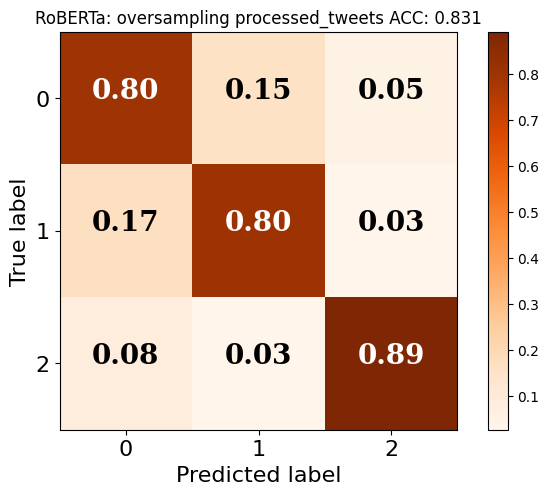


>>> Tipo do experimento: processed_tweets - undersampling
              precision    recall  f1-score   support

           0       0.24      0.71      0.36       290
           1       0.97      0.82      0.89      3832
           2       0.84      0.89      0.86       835

    accuracy                           0.83      4957
   macro avg       0.69      0.80      0.70      4957
weighted avg       0.91      0.83      0.86      4957

ACC balanceada testset - undersampling - processed_tweets: 0.805




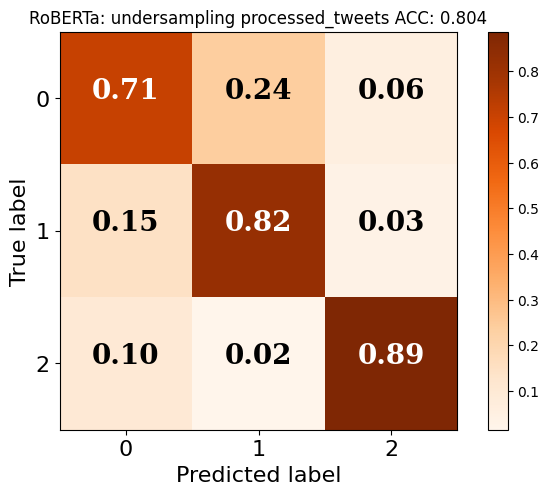


>>> Tipo do experimento: tweet - oversampling
              precision    recall  f1-score   support

           0       0.21      0.79      0.33       290
           1       0.98      0.76      0.85      3832
           2       0.82      0.90      0.86       835

    accuracy                           0.78      4957
   macro avg       0.67      0.81      0.68      4957
weighted avg       0.91      0.78      0.82      4957

ACC balanceada testset - oversampling - tweet: 0.814




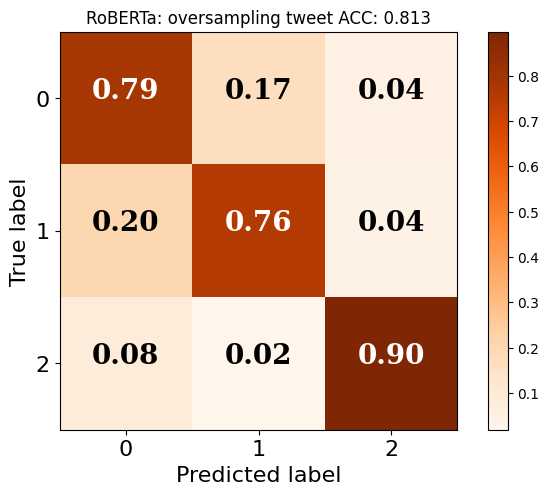


>>> Tipo do experimento: tweet - undersampling
              precision    recall  f1-score   support

           0       0.19      0.80      0.30       290
           1       0.98      0.70      0.82      3832
           2       0.81      0.93      0.87       835

    accuracy                           0.75      4957
   macro avg       0.66      0.81      0.66      4957
weighted avg       0.91      0.75      0.80      4957

ACC balanceada testset - undersampling - tweet: 0.81




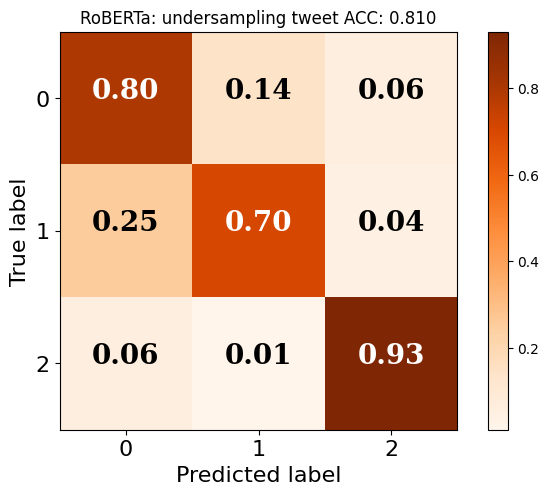

In [ ]:
for processing_datatype in list(results.keys()):
    for data in results[processing_datatype]:
        for balancing_type, values in data.items():
            print(f'\n>>> Tipo do experimento: {processing_datatype} - {balancing_type}')

        if processing_datatype == 'processed_tweets':
            df_test = pd.read_csv(base_path+"test.csv", index_col=None)

            df_test[processing_datatype] = df_test.tweet.apply(lambda x: clean_text(x))

            X_test, y_test = df_test[processing_datatype], df_test['class']
            test_texts, test_labels = get_tokens(X_test.to_list(), y_test.to_list(), MAX_LEN)
            dataset_test = TensorDataset(test_texts, test_labels)
            test_loader = DataLoader(dataset=dataset_test, batch_size=128, shuffle=False)

            _, acc_test, trues, preds  = evaluate(values[1][0], test_loader, device)

        else:
            df_test = pd.read_csv(base_path+"test.csv", index_col=None)

            X_test, y_test = df_test[processing_datatype], df_test['class']
            test_texts, test_labels = get_tokens(X_test.to_list(), y_test.to_list(), MAX_LEN)
            dataset_test = TensorDataset(test_texts, test_labels)
            test_loader = DataLoader(dataset=dataset_test, batch_size=128, shuffle=False)

            # tem que escolher um modelo do k-fold: trained_models[K]
            _, acc_test, trues, preds  = evaluate(values[1][0], test_loader, device)


        cm = confusion_matrix(trues, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        np.set_printoptions(precision=1)

        fig, ax = plt.subplots()

        title="RoBERTa: " + balancing_type + " " + processing_datatype + ' - ACC: ' + str(acc_test)[:5]
        plot_confusion_matrix(cm=cm_normalized, title=title)
        plt.savefig(title+".png",bbox_inches='tight')
        print(classification_report(trues, preds))
        print(f"ACC balanceada testset - {balancing_type} - {processing_datatype}: {acc_test:.3}\n\n")
        plt.show()

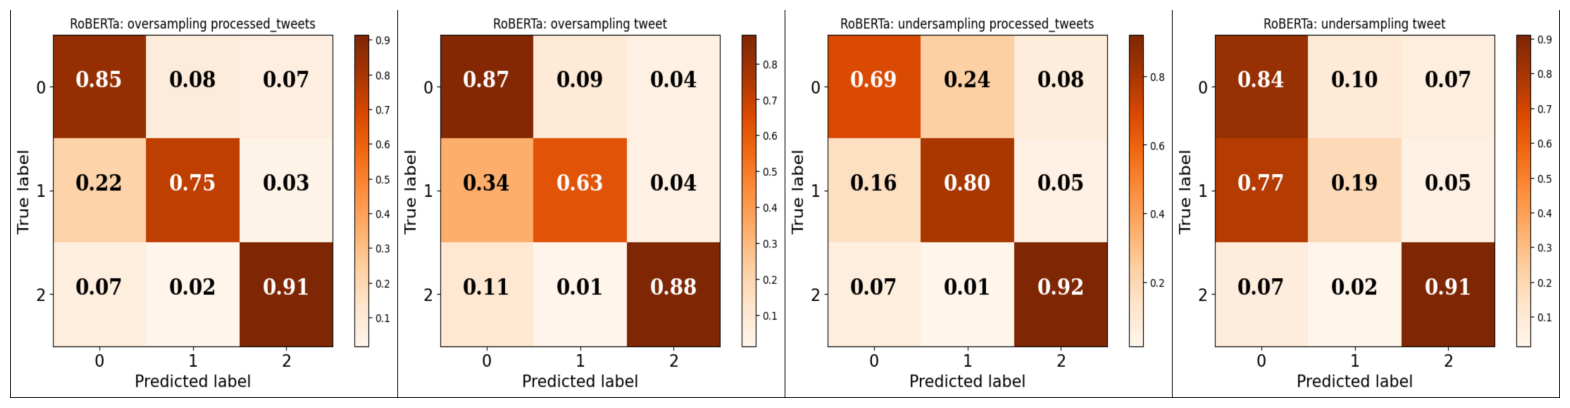

In [ ]:
import torch
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),  # Redimensiona a imagem
        transforms.ToTensor()           # Converte para tensor
    ])
    # Carrega a imagem
    image = Image.open(image_path).convert('RGB')
    # Aplica a transformação
    return transform(image)

base = "/content/RoBERTa: "
image_paths = [
    base+"oversampling processed_tweets.png",
    base+"oversampling tweet.png",
    base+"undersampling processed_tweets.png",
    base+"undersampling tweet.png",
    ]
# Carrega as imagens
images = [load_image(image_path) for image_path in image_paths]

# Cria um grid com as imagens
grid = make_grid(images, nrow=4)  # nrow define o número de imagens por linha

# Converte o tensor do grid para uma imagem numpy para exibição
grid_image = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(20, 8))  # Ajuste o tamanho conforme necessário
plt.imshow(grid_image)
plt.axis('off')  # Remove os eixos
plt.show()